# LDA Optimizado

Luego de correr la optimizacion en 02-LDA seleccioné la cantidad de tópicos, corrí el modelo y agregué WE

In [117]:
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
import gensim

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk

import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold
import time

start_time = time.time()

%matplotlib inline

from playsound import playsound


sys.path.append("../source")


In [118]:
import random
random.seed(100)
random_state = 100

In [119]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from gensim.models.phrases import Phrases, Phraser

In [120]:
path_nps_2020 = "..\\data\\original\\2020\\"
processed_2020  = "..\\data\\processed\\2020\\" 
path_data_processed = "..\\data\\processed\\"
path2019 = "..\\data\\original\\2019\\"
sonido = "..\\figures\\sonidos\\"

In [121]:
comments = pd.read_csv(processed_2020 +"comments.csv")
print(f"Tamaño del Dataset: {comments.shape}")

Tamaño del Dataset: (63752, 40)


In [122]:
 comments["token"]

0        ['servicio', 'bueno', 'auxilio', 'satisfactori...
1                                ['agilidad', 'comodidad']
2        ['an', 'llegado', 'horario', 'aproximado', 'ha...
3        ['bueno', 'atencion', 'servicio', 'espero', 't...
4                          ['costo', 'servicios', 'bueno']
                               ...                        
63747    ['eleccion', 'baso', 'caja', 'ofrece', 'seguro...
63748    ['cordialidad', 'atencion', 'rapidez', 'soluci...
63749                                ['bueno', 'atencion']
63750    ['siempre', 'honestos', 'ultimo', 'tiempo', 'p...
63751    ['rapidez', 'asegurar', 'ningun', 'inconvenien...
Name: token, Length: 63752, dtype: object

In [123]:
word_list = comments.token.tolist()

In [124]:
print("el corpus tiene",len(word_list), "oraciones y",sum([len(x) for x in word_list]),"palabras")

el corpus tiene 63752 oraciones y 5846649 palabras


In [125]:
def sent_to_words(sentences):
    for sentence in sentences:
        #vuelve todo a lower case y saca puntuaciones y convierte cada documento de texto en una lista de palabras
        yield(gensim.utils.simple_preprocess(str(sentence), deacc =True))

In [126]:
train_w = list(sent_to_words(word_list))

In [127]:
collocations = Phrases(sentences=train_w, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado

In [128]:
to_collocations = Phraser(collocations)

In [129]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(train_w)],columns=["bigram","score"])
df_collocations.shape

(25460, 2)

In [130]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(50)

,bigram,score
2116,b'suran trendline',1.000000
177,b'call center',0.988584
2112,b'sebastian hahn',0.980027
433,b'on line',0.978842
2531,b'ayudaran haganlo',0.975905
4151,b'sabados domingos',0.975905
7038,b'stop debit',0.967467
3545,b'federacion patronal',0.965707
953,b'detallo continuacion',0.946019
1831,b'toca vivir',0.932411


In [131]:
trainset_ngrams = to_collocations[train_w]

In [132]:
# Save / load an exported collocation model.
trainset_ngrams.save(processed_2020+"bigrams2019.pkl")

In [17]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

In [18]:
dictionary = corpora.Dictionary(trainset_ngrams)

In [19]:
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in trainset_ngrams] #convierto cada documente a un 

In [20]:
ldamodel = LdaModel(corpus=corpus, num_topics=18, id2word=dictionary, iterations = 500, passes=12, random_state=random_state)

In [21]:
ldamodel.print_topics(18, 10)

[(0,
  '0.091*"empresa" + 0.075*"clientes" + 0.074*"experiencia" + 0.049*"informacion" + 0.041*"situacion" + 0.034*"vez" + 0.025*"respecto" + 0.025*"solicitado" + 0.022*"confiable" + 0.020*"beneficio"'),
 (1,
  '0.101*"respuesta" + 0.055*"reclamo" + 0.052*"forma" + 0.050*"dieron" + 0.034*"hice" + 0.028*"inmediata" + 0.024*"solucion" + 0.024*"dicen" + 0.024*"contestaron" + 0.021*"vehiculos"'),
 (2,
  '0.360*"atencion" + 0.070*"cliente" + 0.044*"maloa" + 0.036*"comunicacion" + 0.032*"telefonica" + 0.020*"personal" + 0.019*"persona" + 0.018*"amable" + 0.017*"sido" + 0.013*"malo"'),
 (3,
  '0.033*"auto" + 0.025*"seguro" + 0.022*"caja" + 0.019*"tenia" + 0.019*"baja" + 0.018*"vehiculo" + 0.017*"si" + 0.016*"pago" + 0.015*"poliza" + 0.014*"dijeron"'),
 (4,
  '0.087*"auxilio" + 0.048*"tiempo" + 0.044*"whatsapp" + 0.030*"telefono" + 0.029*"mas" + 0.028*"veces" + 0.026*"demora" + 0.018*"minutos" + 0.016*"espera" + 0.015*"llame"'),
 (5,
  '0.067*"descuento" + 0.052*"poliza" + 0.041*"meses" + 0.02

In [22]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=trainset_ngrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4784259857740109


In [23]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(25,formatted=False)]

In [24]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=trainset_ngrams, dictionary=dictionary, window_size=30,coherence='c_npmi',topn=5).get_coherence_per_topic()

In [25]:
df_lda = pd.DataFrame([range(25),lda_coherence,ldatopics],index=['topic_id','coherence','topic']).transpose()

In [26]:
df_lda.sort_values(by='coherence',ascending=False)[:18]

,topic_id,coherence,topic
7,7,0.145245,"[seguro, caja, mas, anos, cliente, seguros, ha..."
3,3,0.130657,"[auto, seguro, caja, tenia, baja, vehiculo, si..."
5,5,0.106511,"[descuento, poliza, meses, seguro, mail, mes, ..."
2,2,0.0961815,"[atencion, cliente, maloa, comunicacion, telef..."
14,14,0.0863786,"[si, dia, dias, seguro, hace, aun, mismo, reci..."
1,1,0.0835991,"[respuesta, reclamo, forma, dieron, hice, inme..."
8,8,0.0571673,"[conforme, momento, valor, cuota, dan, cuenta,..."
12,12,0.03568,"[problema, siempre, nunca, solucion, cumplimie..."
11,11,0.0355278,"[rapidez, respuesta, eficiencia, consulta, ati..."
4,4,0.0292537,"[auxilio, tiempo, whatsapp, telefono, mas, vec..."


In [27]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

c:\Users\fede_\.vscode\extensions\ms-python.python-2020.8.109390\pythonFiles\lib\python\past\types\oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.270280 -0.035390       1        1  12.969236
7      0.222544 -0.034610       2        1   9.593761
5      0.279695 -0.024939       3        1   9.134733
14     0.224194 -0.070068       4        1   7.124339
2     -0.075496  0.260500       5        1   6.129178
4      0.104570  0.031684       6        1   6.093167
17    -0.120468  0.257082       7        1   5.971011
11    -0.204910 -0.249475       8        1   5.198585
12    -0.080294 -0.092454       9        1   4.775436
15     0.037041  0.065640      10        1   4.614442
8      0.060699 -0.018953      11        1   4.531754
1     -0.130308 -0.203032      12        1   4.448779
9     -0.082345  0.057814      13        1   3.604150
13    -0.059287  0.018773      14        1   3.451958
0     -0.053449  0.043210      15        1   3.350716
6     -0.159346 -0.200705      16        1   3.172763
10    -0.112868  0.086133      17        1   3.043757
16    -0.120251  0.108793      18        1   2.792236, topic_info=               Term          Freq         Total Category  logprob  loglift
1             bueno  11432.000000  11432.000000  Default  30.0000  30.0000
76         atencion  13871.000000  13871.000000  Default  29.0000  29.0000
36          rapidez   8936.000000   8936.000000  Default  28.0000  28.0000
21   bueno_atencion   7300.000000   7300.000000  Default  27.0000  27.0000
37        respuesta  10002.000000  10002.000000  Default  26.0000  26.0000
..              ...           ...           ...      ...      ...      ...
301      telefonica    272.564235   1280.192158  Topic18  -3.9564   2.0314
146        personal    187.003104   1013.097098  Topic18  -4.3332   1.8887
960           parte    157.326204    773.825236  Topic18  -4.5060   1.9853
530          recibi     71.487307    729.850015  Topic18  -5.2948   1.2550
222        mecanico     50.815948    277.215474  Topic18  -5.6361   1.8817

[823 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
944      18  0.968986  abogados
666       3  0.996265    abonar
413       1  0.103367       aca
413       6  0.893817       aca
1776      7  0.977257   acarreo
...     ...       ...       ...
497      16  0.992725   vueltas
892       5  0.769636       web
892      13  0.228408       web
331       6  0.999223  whatsapp
717      14  0.996375        xq

[1004 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 6, 15, 3, 5, 18, 12, 13, 16, 9, 2, 10, 14, 1, 7, 11, 17])

In [28]:
topics_df = pd.DataFrame(ldamodel.print_topics(num_topics=10), columns=["topic", "word_prob"])

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
topic_dict = dict(zip(topics_df["topic"], topics_df["word_prob"]))

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
topics_df.to_csv(processed_2020+"optimizados_topics.csv")

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Oraciones más representativas por tópico


In [31]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=comments["TNPS_COMMENT"])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.3611,"bueno, servicio, atencion, precio, trato, pred...","el servicio es bueno , el auxilio es muy satis..."
1,1,0.0,0.6852,"empresa, clientes, experiencia, informacion, s...",Agilidad y comodidad
2,2,1.0,0.3818,"respuesta, reclamo, forma, dieron, hice, inmed...",Porque an llegado al horario aproximado que me...
3,3,16.0,0.1508,"bueno_atencion, costo, relacion, solicitud, so...",Buena atención y servicio. Espero no tener que...
4,4,17.0,0.2639,"bueno, servicio, atencion, precio, trato, pred...",El costo con los servicios es muy bueno
5,5,14.0,0.5802,"si, dia, dias, seguro, hace, aun, mismo, recie...",me debitaron un importe inesperado sin anuncio...
6,6,11.0,0.5070,"rapidez, respuesta, eficiencia, consulta, atie...",SIEMPRE HE TENIDO BUEN TRATO Y EFICIENCIA RAP...
7,7,11.0,0.3774,"rapidez, respuesta, eficiencia, consulta, atie...",Respondieron rápido a mi pedido de auxilio mec...
8,8,17.0,0.7569,"bueno, servicio, atencion, precio, trato, pred...",el exelente servicio que bridan aparte tienen ...
9,9,11.0,0.6852,"rapidez, respuesta, eficiencia, consulta, atie...","Siempre me.respondierom cuando los.necesited ,..."


In [32]:
df_dominant_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63752 entries, 0 to 63751
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Document_No         63752 non-null  int64  
 1   Dominant_Topic      63752 non-null  float64
 2   Topic_Perc_Contrib  63752 non-null  float64
 3   Keywords            63752 non-null  object 
 4   Text                63752 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.4+ MB
C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Tageos de Tópicos en el Dataset

In [33]:
topico_df = pd.merge(comments, df_dominant_topic, left_index=True, right_index=True)

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
topico_df.head().T

C:\Users\fede_\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
CREATION_DATE,2/3/2020 10:31:59,2/3/2020 10:30:04,2/3/2020 10:30:04,2/3/2020 10:30:04,2/3/2020 10:30:04
RESPONSE_DATE,2/3/2020 23:27:25,2/3/2020 10:37:39,2/3/2020 17:43:29,2/3/2020 17:23:58,2/3/2020 17:46:20
ALL_LOG_NOTES_COMBINED,[2020-03-02 18:27:50] Alert Created: Promoter ...,[2020-03-02 05:38:09] Alert Created: Promoter ...,[2020-03-02 12:43:36] Alert Created: Promoter ...,[2020-03-02 12:24:28] Alert Created: Promoter ...,NaN
TITLE,Estimado,Estimado,Estimado,Estimado,Estimado
DOCUMENT_TYPE,DNI,DNI,DNI,LE,DNI
DOCUMENT_NUMBER,13386899,16446557,18786662,8376933,21679144
FIRST_NAME,GUSTAVO,RICARDO DANIEL,OSCAR,ALFREDO DIONISIO,ALEJANDRO HECTOR
LAST_NAME,TARIFA,LUCERO,MITA,PACHECO,COLOMBO
GENDER,M,M,M,M,M


# Embeddings

In [133]:
bigram_reloaded = trainset_ngrams

In [134]:

w2v_model = Word2Vec(bigram_reloaded, workers=4,size=20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)
#w2v_model.save("word2vec_20dim")  # save model
#w2v_model = Word2Vec.load("word2vec_20dim")  # load model

In [135]:
w2v_model.most_similar(positive=["tarjeta"], topn=100)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('debito_automatico', 0.9203954935073853),
 ('activa', 0.8933643102645874),
 ('tarjeta_nativa', 0.8868395686149597),
 ('nombre_papa', 0.8861855864524841),
 ('visa', 0.8823490738868713),
 ('targeta', 0.8808049559593201),
 ('tarjeta_credito', 0.8792763352394104),
 ('seg', 0.8783552646636963),
 ('ingrese', 0.8756300210952759),
 ('saldo', 0.8715663552284241),
 ('mastercard', 0.869943380355835),
 ('cuenta_bancaria', 0.8681777715682983),
 ('pido_manden', 0.860420286655426),
 ('permitio', 0.8555852770805359),
 ('acredito', 0.8552367091178894),
 ('home_banking', 0.8545616865158081),
 ('clave_electronica', 0.8539363145828247),
 ('banco_nacion', 0.8535411357879639),
 ('talon', 0.8528957366943359),
 ('fechas', 0.8469697833061218),
 ('privado', 0.8453403115272522),
 ('adherido', 0.8445583581924438),
 ('impaga', 0.8443506956100464),
 ('modalidad', 0.8414095044136047),
 ('vto', 0.8403061628341675),
 ('esperando_devuelvan', 0.839732825756073),
 ('rechazado', 0.8394162654876709),
 ('banco', 0.8356835

In [20]:
w2v_model.most_similar(positive=["rapidez"], topn=100)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('eficiencia', 0.9333106279373169),
 ('prontitud', 0.9189900159835815),
 ('velocidad', 0.9155351519584656),
 ('efectividad', 0.89975905418396),
 ('cordialidad', 0.8856852650642395),
 ('optimo', 0.8826871514320374),
 ('planteados', 0.880748450756073),
 ('predispuestos', 0.8668773174285889),
 ('bueno_atencion', 0.8665967583656311),
 ('recomendables', 0.8577691316604614),
 ('expeditivos', 0.8492136597633362),
 ('practicidad', 0.8486517071723938),
 ('todas_dudas', 0.8445007801055908),
 ('referido', 0.8442251682281494),
 ('felicitaciones', 0.8404552936553955),
 ('inmediata', 0.8402537703514099),
 ('sencilla', 0.839962363243103),
 ('diligencia', 0.8374159932136536),
 ('asociarme', 0.8353820443153381),
 ('bueno', 0.8315210342407227),
 ('facilmente', 0.831067681312561),
 ('claras', 0.8284671306610107),
 ('simplicidad', 0.8266181945800781),
 ('relativamente', 0.8253199458122253),
 ('expeditiva', 0.8211846351623535),
 ('buenos', 0.8202588558197021),
 ('agil', 0.8183895349502563),
 ('mecanicos',

In [21]:
w2v_model.most_similar(positive=["servicio"], topn=100)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('prestado', 0.8825079202651978),
 ('prestacion', 0.8731110692024231),
 ('prestan', 0.8654688596725464),
 ('bueno', 0.8621531128883362),
 ('contenta', 0.8565322160720825),
 ('recomendable', 0.8553596138954163),
 ('mayormente', 0.8389310240745544),
 ('contratando', 0.8368598222732544),
 ('conforme', 0.8304799795150757),
 ('presta', 0.8287203907966614),
 ('acudieron', 0.8277833461761475),
 ('agrada', 0.8238347172737122),
 ('auxilios', 0.8165557384490967),
 ('ayuda_mecanica', 0.8156355023384094),
 ('desconozco', 0.8140623569488525),
 ('explicada', 0.812431812286377),
 ('fluidez', 0.8089343905448914),
 ('referencias', 0.8086042404174805),
 ('lineas_telefonicas', 0.8043853044509888),
 ('servico', 0.7999656200408936),
 ('aranceles', 0.7983978986740112),
 ('super', 0.7978343963623047),
 ('brindado', 0.7908875346183777),
 ('favorables', 0.7904781103134155),
 ('confiables', 0.7901378273963928),
 ('desempeno', 0.7898126840591431),
 ('buenos', 0.7888070344924927),
 ('puedo_calificar', 0.78793525

In [22]:
w2v_model.most_similar(positive=["vehiculos"], topn=100)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('flia', 0.8736592531204224),
 ('autos', 0.8555338978767395),
 ('muchisimos_anos', 0.8306294679641724),
 ('automoviles', 0.829579770565033),
 ('vehiculos_asegurados', 0.8242225646972656),
 ('tenerlo', 0.8205020427703857),
 ('integrantes', 0.8115903735160828),
 ('gasto', 0.803835928440094),
 ('autos_asegurados', 0.7911782264709473),
 ('asegurados', 0.7907627820968628),
 ('actualidad', 0.7899304628372192),
 ('asegurado', 0.7859898209571838),
 ('aseguro', 0.7842624187469482),
 ('robos', 0.7836763858795166),
 ('ido', 0.7826492786407471),
 ('oscar', 0.780371904373169),
 ('seguros', 0.778997004032135),
 ('automotores', 0.7782657742500305),
 ('poseo', 0.7749658226966858),
 ('recomendado', 0.7733356952667236),
 ('recientemente', 0.7719534039497375),
 ('estimados', 0.766844630241394),
 ('vida', 0.7661939859390259),
 ('hurto', 0.7661895751953125),
 ('locales', 0.7641541957855225),
 ('muerte', 0.7621641755104065),
 ('todas_cias', 0.7589430809020996),
 ('aseguran', 0.7561839818954468),
 ('viviend

In [23]:
w2v_model.most_similar(positive=["facilidad"], topn=100)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('practico', 0.9170558452606201),
 ('agilidad', 0.9110183119773865),
 ('comodidad', 0.9093493223190308),
 ('practicidad', 0.9080319404602051),
 ('simplicidad', 0.8817218542098999),
 ('plataforma', 0.8806313276290894),
 ('agil', 0.8792504072189331),
 ('tantas_vueltas', 0.8739646077156067),
 ('sencillez', 0.8734282851219177),
 ('on_line', 0.8727242946624756),
 ('online', 0.8720951080322266),
 ('simpleza', 0.8713819980621338),
 ('operar', 0.8672595620155334),
 ('sencillo', 0.8576953411102295),
 ('metodo', 0.8566691279411316),
 ('facilidad_contratacion', 0.8541887402534485),
 ('sencilla', 0.839712381362915),
 ('cuestiones_administrativas', 0.8389841914176941),
 ('asociarme', 0.8355906009674072),
 ('practica', 0.8339464664459229),
 ('comodo', 0.8336775302886963),
 ('simples', 0.8273853659629822),
 ('simple', 0.8223053812980652),
 ('remota', 0.8199853301048279),
 ('precios_competitivos', 0.8163216710090637),
 ('facilitaron', 0.811313271522522),
 ('sitio_web', 0.8101851940155029),
 ('contrat

In [24]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = w2v_model.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{0} es a {1}, lo que {2} es a {3}".format(start1, end1, start2, end2))

In [25]:
nearest_similarity_cosmul("auxilio", "atencion", "bueno")

auxilio es a atencion, lo que conductor es a bueno


In [26]:
nearest_similarity_cosmul("auxilio", "auxicaja", "malo")

auxilio es a auxicaja, lo que traslado es a malo


In [43]:
from sklearn.decomposition import PCA


In [107]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 6,6


In [108]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


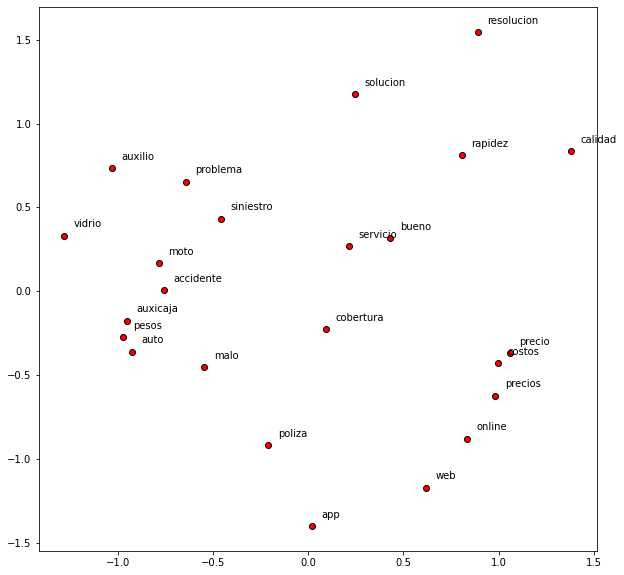

In [109]:


display_pca_scatterplot(w2v_model, 
                        ['auxilio','auxicaja','problema','malo','bueno','calidad','rapidez','costos','precios','precio','siniestro','poliza','auto','servicio','solucion','resolucion','cobertura','accidente','moto','vidrio','pesos','online','app','web'])


In [110]:
def display_closestwords_tsnescatterplot(model, word):
    vector_dim = model.vector_size
    arr = np.empty((0,vector_dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


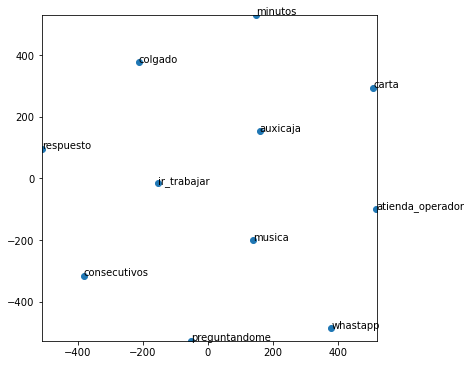

In [111]:
display_closestwords_tsnescatterplot(w2v_model, 'auxicaja')


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


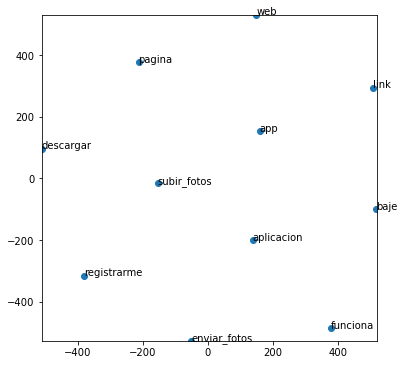

In [112]:
display_closestwords_tsnescatterplot(w2v_model, 'app')


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


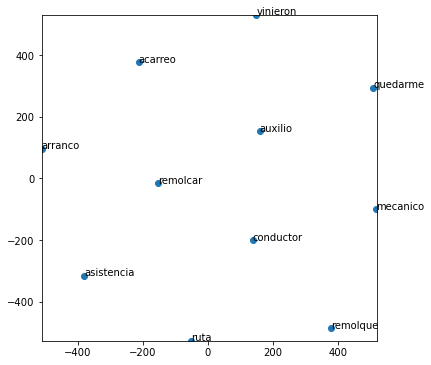

In [113]:
display_closestwords_tsnescatterplot(w2v_model, 'auxilio')


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


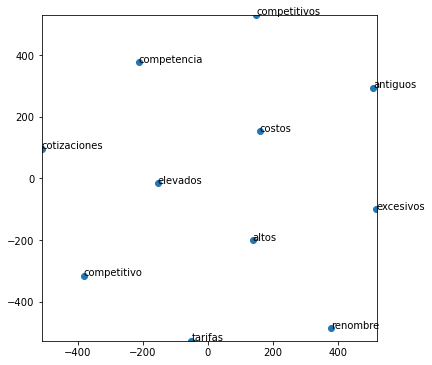

In [114]:
display_closestwords_tsnescatterplot(w2v_model, 'costos')


C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\topic_modelling\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


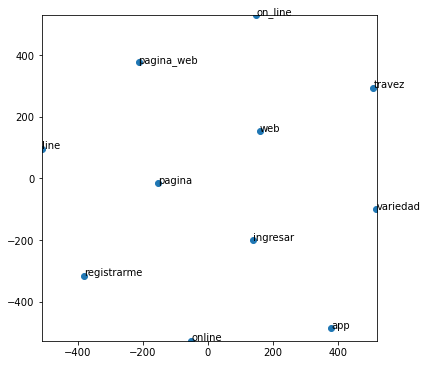

In [116]:
display_closestwords_tsnescatterplot(w2v_model, 'web')


In [33]:
print("--- %s segundos---" % (time.time() - start_time))
playsound(sonido+"war.mp3")
import gc
gc.collect()a

--- 644.5316824913025 segundos---


349887